# microtubules analysis

## -- detection, orientation correlation & local curvature

### for Pauline Durand

## feature request:

1. blah
2. dfsf
2. fdsf

In [1]:
# %matplotlib notebook
%matplotlib inline
# %load_ext ipycache
# %mkdir -vp ipycache
import numpy as np
from matplotlib import pyplot as plt

# import mpld3
# mpld3.enable_notebook()
# mpld3.disable_notebook()

import platform
from datetime import datetime as dt
import pandas as pd
from glob import glob
import os #,sys
hostname = platform.node()
print 'This cell was run last at {} on \n\t{}'.format( dt.now(), hostname)
# print('This cell was run last at {} on \n\t{}'.format( dt.now(), hostname))

This cell was run last at 2016-11-22 14:14:12.937189 on 
	thaliana


In [2]:
##  load (and compile if necessary) the ridge_directed_ring_detector
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()})

import ridge_directed_ring_detector as ring_detector

Read in CZI files

**depends: python-bioformats**

[parse_xml_metadata](https://github.com/jni/lesion/blob/c3223687d35a7f81da7305e1e041f9c5a53104b1/lesion/lifio.py#L79)

```python
import javabridge as jv, bioformats as bf
jv.start_vm(class_path=bf.JARS, max_heap_size='8G')

from xml.etree import ElementTree as ETree

DEFAULT_DIM_ORDER = 'tzyxc'
from xml import etree as et

def parse_xml_metadata(xml_string, array_order=DEFAULT_DIM_ORDER):
    """Get interesting metadata from the LIF file XML string.
    Parameters
    ----------
    xml_string : string
        The string containing the XML data.
    array_order : string
        The order of the dimensions in the multidimensional array.
        Valid orders are a permutation of "tzyxc" for time, the three
        spatial dimensions, and channels.
    Returns
    -------
    names : list of string
        The name of each image series.
    sizes : list of tuple of int
        The pixel size in the specified order of each series.
    resolutions : list of tuple of float
        The resolution of each series in the order given by
        `array_order`. Time and channel dimensions are ignored.
    """
    array_order = array_order.upper()
    names, sizes, resolutions = [], [], []
    spatial_array_order = [c for c in array_order if c in 'XYZ']
    size_tags = ['Size' + c for c in array_order]
    res_tags = ['PhysicalSize' + c for c in spatial_array_order]
    metadata_root = et.ElementTree.fromstring(xml_string)
    for child in metadata_root:
        if child.tag.endswith('Image'):
            names.append(child.attrib['Name'])
            for grandchild in child:
                if grandchild.tag.endswith('Pixels'):
                    att = grandchild.attrib
                    sizes.append(tuple([int(att[t]) for t in size_tags]))
                    resolutions.append(tuple([float(att[t])
                                              for t in res_tags]))
    return names, sizes, resolutions


def metadata_summary(names, sizes, resolutions):
    header = '{} -- metadata summary'.format(names[0])
    print header
    print '='*len(header)

    print '\nsizes:'
    for d,s in zip(DEFAULT_DIM_ORDER, sizes[0]):
        print '\t{} :\t{:3}'.format(d,s)

    print '\nmicrons to pixels ratio:'
    for d,s in zip('zyx', resolutions[0]):
        print '\t{} :\t{:.3f} um/px'.format(d,s)
```  

```python
czi_name = '../16-01-21/fabdgfpc1square.czi'
md = bf.get_omexml_metadata(czi_name)
names, sizes, resolutions = parse_xml_metadata(md.encode('utf8'))
```

### TODO:

1. detect ridges, representing the u-tubules coordnates and local orientaion
    1. ridge detection, possibly look at the tangent to the ridge ($\pi/2$ w.r.t. the output)
2. find correlation length of the orientation
    1. calculate $r = dist_{\vec{u}, \vec{v}}$  and $\vartheta_{\vec{u}, \vec{v}}$
    2. groupby $r$ bins and average over each bin to get $\langle \vartheta (r)  \rangle$
    
3. ** Improtance of 3d: On the Square comare the upper three slices, bottom three slices and max projection**
4. ** Effect of noise : analyse inside the vacuole where there are no actin fibers ** 
5. ** effect of alignment: rotate by 45 deg **


In [3]:
## interactive parameter choice
#from IPython.html.widgets import interact, interactive, fixed
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

cmap = plt.cm.magma
figsize = (10,10)

plt_hist = ['hist', 'kde'][0]

out = None

## get directed ridges
def get_directed_ridges(img, sigma=5, curv_thresh=-.5):
    '''
    img 
        image like array to analyse
        
    sigma
        width of smoothing gaussian
        
    curve_thresh
        threshold for minimal principal curvature
    '''
    ridge_hough = ring_detector.RidgeHoughTransform(img.astype(np.float32))
    ridge_hough.params['sigma'] = sigma
    ridge_hough.params['curv_thresh'] = curv_thresh
    ridge_hough.img_preprocess()
    ridge_hough.directed_ridge_detector()
    # ridge_hough.rings_detection()

    mask = np.zeros_like(img)
    cosQ,sinQ = np.zeros_like(img),np.zeros_like(img)
    directed_ridges = ridge_hough.output['directed_ridges']

    for coord,value in directed_ridges.iteritems():
        mask[coord]+=1
        cosQ[coord],sinQ[coord] = value

    mask = mask!=0
    #hough.ImPxlInfo(mask)

    nrows,ncols = img.shape
    y,x = np.mgrid[0:nrows,0:ncols]
    
    ## add new attributes:
    ridge_hough.directed_ridges = {'x':x, 'y':y, 'cosQ':cosQ, 'sinQ':sinQ, 'mask':mask}
    return ridge_hough


def plot_directed_ridges(ridge_hough, arr_colour='k', figsize = figsize):
    
    mask = ridge_hough.directed_ridges['mask']
    arr_scale = 22
    arr_units = 'dots'#'xy'
    arr_headwidth = None#2
    fig = plt.figure(figsize=figsize)
    n = 1
    
    x,y = ridge_hough.directed_ridges['x'],ridge_hough.directed_ridges['y']
    cosQ, sinQ = ridge_hough.directed_ridges['cosQ'],ridge_hough.directed_ridges['sinQ']

    for img2plot, cmap in [[ridge_hough.img, plt.cm.gnuplot], 
                           [ridge_hough.deriv['principal_curv'], plt.cm.gnuplot_r]]:
        ax = plt.subplot(2,1,n)
        im = ax.imshow(img2plot,cmap=cmap, interpolation='nearest', origin='top')
        plt.colorbar(im)
#         ax.set_axis_off()
        quiveropts = dict(color='white', 
                          headlength=0, pivot='middle', #scale=3, 
                        linewidth=.5, 
                          units='xy', 
                          width=.05, headwidth=1,
#                          headaxislength=0
                         )
        ax.quiver(x[mask],y[mask],cosQ[mask],sinQ[mask],
#                   color='none', edgecolors=arr_colour,
#                   linewidths=.8,  scale=400, headwidth=2,
#                   width=.001,linewidth=.5, scale=400,
                  **quiveropts
                 )
        ax.set_aspect('equal')
        n+=1
    ridges = pd.DataFrame(np.transpose([x[mask],y[mask],cosQ[mask],sinQ[mask]]), columns=['x','y','cosQ','sinQ'])\
                .set_index(['x','y'])
#     ridges = [x[mask],y[mask],cosQ[mask],sinQ[mask]]
    return ridges
    
        
def pipeline(img, sigma=1, curv_thresh=-.5, arr_colour='k'):
    global out
    ridge_hough = get_directed_ridges(img, sigma, curv_thresh)
    ridges = plot_directed_ridges(ridge_hough, arr_colour=arr_colour)
    out = ridge_hough ,ridges 

# Load the data

In [133]:
img_ext = 'png'
img_dir = '/home/pdurand/Pictures/actin rectangles/16_09_27'
exmpl_imgs = sorted(glob('{}/*.{}'.format(img_dir, img_ext)))
fig_out_dir  = '../figures'

In [134]:
img = plt.imread(exmpl_imgs[0])

Found the following img files:
[0]	/home/pdurand/Pictures/actin rectangles/16_09_27/MAX_C1-fabd gfp rectangle1.png
[1]	/home/pdurand/Pictures/actin rectangles/16_09_27/MAX_C1-fabd gfp rectangle2.png


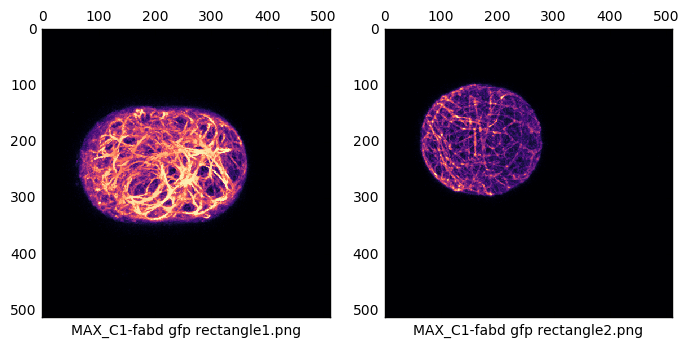

In [135]:
nimgs = len(exmpl_imgs)
imsize = 3.5

Figs, Ax = plt.subplots(1,nimgs,figsize=(nimgs*imsize,imsize))

print 'Found the following img files:'

for n,img_name in enumerate(exmpl_imgs):
    ax = Ax[n]
    img = plt.imread(img_name)[...,0]
    ax.matshow(img, cmap=cmap)
    ax.set_xlabel(os.path.split(img_name)[-1])
    print '[{}]{}{}'.format(n,'\t',img_name)
    
plt.tight_layout()


### Parameter choice

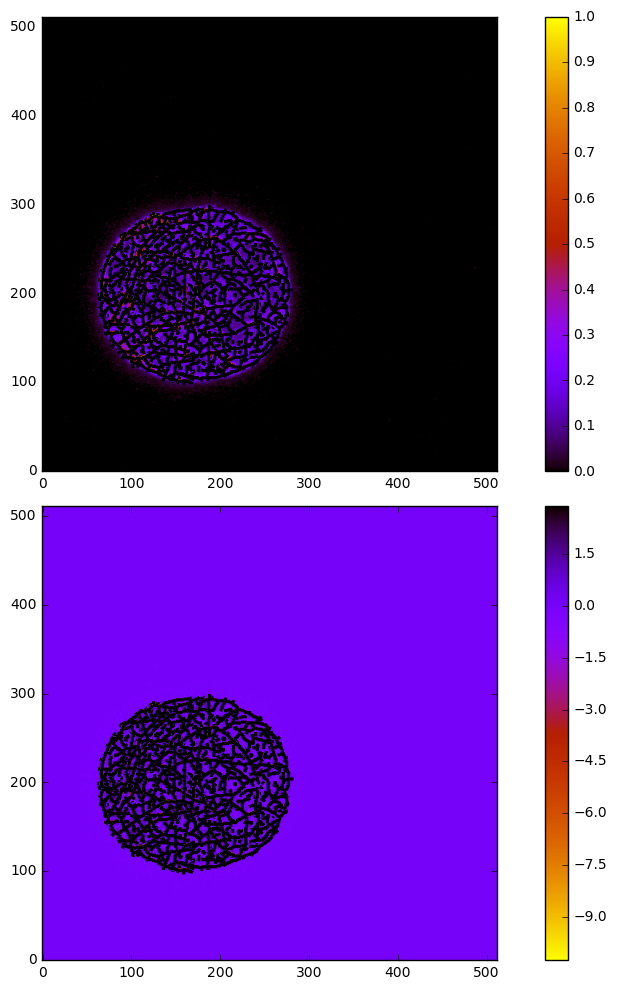

In [137]:
img_name = exmpl_imgs[1]
img = plt.imread(img_name)[...,0]#[150:350,50:480]

try:
    val_range = np.iinfo(img.dtype)
    m,M = val_range.min, val_range.max
except:
    m,M = img.min(), img.max()

img -= m
img = img*1./(M-m)

# out = interact(pipeline, img=fixed(img),

interact(pipeline, img=fixed(img), 
         sigma=(0.1,10,0.1), curv_thresh=(-10,.1,0.01), 
         arr_colour=['black','yellow','green','blue','cyan','none'])

plt.tight_layout()

#for fmt in ['eps','png']:
#    plt.savefig('{}/{}.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)
   
# for fmt in ['eps','png']:
#     plt.savefig('{}/lines_{}.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)
    




bins number = 30


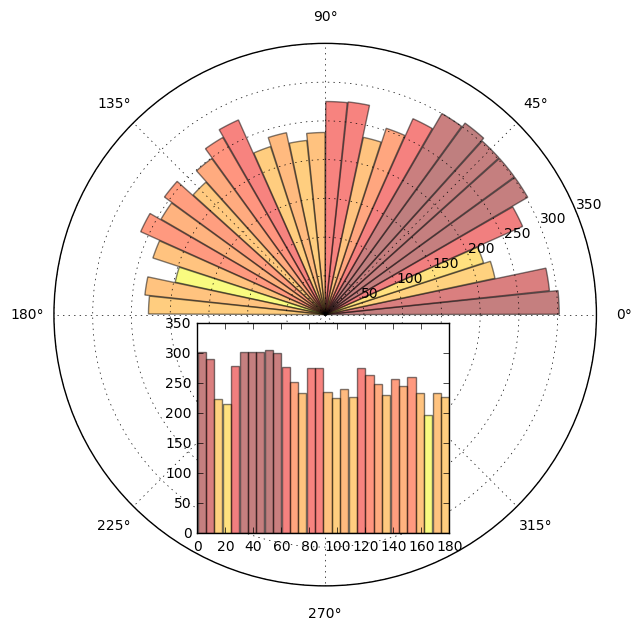

In [138]:
X = out[1]
normedQ = np.arctan2(X.sinQ, X.cosQ ) + 0.5* np.pi

binning = [min(int(np.sqrt(len(normedQ))),180,30), 'auto', 180, 'doane','sqrt'][0]

freq, theta = np.histogram(normedQ, 
                           bins=binning,
#                            normed=1,
                          )
width = np.pi/len(theta)
amp = freq.max()*1.

Fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True )

bars = ax.bar(theta[:-1], freq, width=width, )#bottom=amp/2)

# Use custom colors and opacity
for f, bar in zip(freq, bars):
    bar.set_facecolor(plt.cm.jet(f/amp))
    bar.set_alpha(0.5)
    
ax_ = Fig.add_axes([0.33, .2, .36, .3], 
#                axisbg='y'
              )
bars_ = ax_.bar(theta[:-1]/np.pi*180, freq, width=width/np.pi*180,)
for f, bar_ in zip(freq, bars_):
    bar_.set_facecolor(plt.cm.jet(f/amp))
    bar_.set_alpha(0.5)

# for fmt in ['eps','png']:
#     plt.savefig('{}/{}_slope_hist.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)

print 'bins number = {}'.format(len(freq))

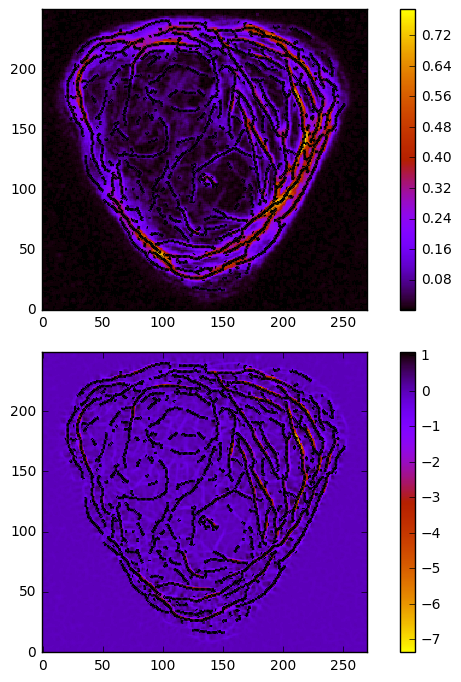

In [20]:
img_name = exmpl_imgs[0]
img = plt.imread(img_name)[170:420,150:420]
val_range = np.iinfo(img.dtype)
img -= val_range.min
img = img*1./(val_range.max-val_range.min)

# out = interact(pipeline, img=fixed(img), 
interact(pipeline, img=fixed(img), 
         sigma=(0.1,10,0.1), curv_thresh=(-10,.1,0.01), 
         arr_colour=['black','yellow','green','blue','cyan','none'])

plt.tight_layout()

for fmt in ['eps','png']:
    plt.savefig('{}/{}.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)


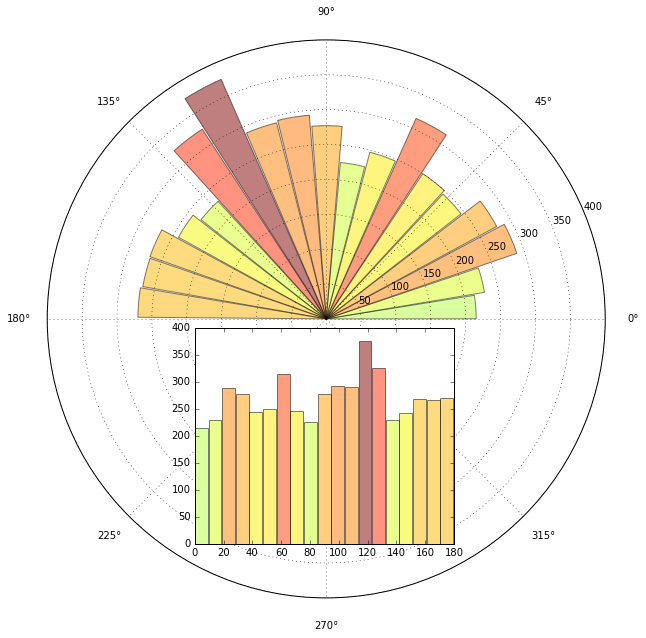

In [181]:
X = out[1]
normedQ = np.arctan2(X.sinQ, X.cosQ ) + 0.5* np.pi

freq, theta = np.histogram(normedQ, 
                           bins='auto',
#                            normed=1,
                          )
width = np.pi/len(theta)
amp = freq.max()*1.

Fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True )

bars = ax.bar(theta[:-1], freq, width=width, )#bottom=amp/2)

# Use custom colors and opacity
for f, bar in zip(freq, bars):
    bar.set_facecolor(plt.cm.jet(f/amp))
    bar.set_alpha(0.5)
    
ax_ = Fig.add_axes([0.33, .2, .36, .3], 
#                axisbg='y'
              )
bars_ = ax_.bar(theta[:-1]/np.pi*180, freq, width=width/np.pi*180,)
for f, bar_ in zip(freq, bars_):
    bar_.set_facecolor(plt.cm.jet(f/amp))
    bar_.set_alpha(0.5)

for fmt in ['eps','png']:
    plt.savefig('{}/{}_slope_hist.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)


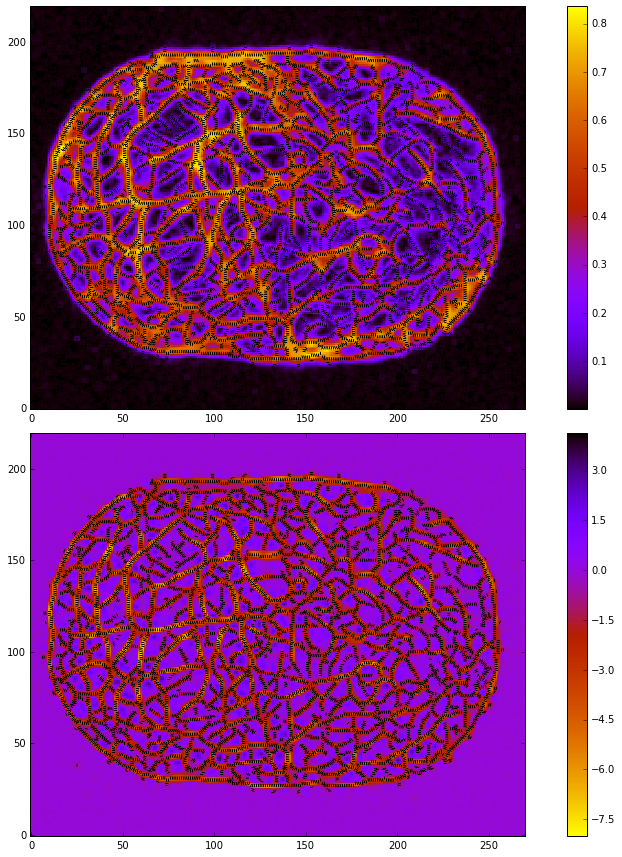

In [182]:
img_name = exmpl_imgs[9]
img = plt.imread(img_name)[100:320,100:370]
val_range = np.iinfo(img.dtype)
img -= val_range.min
img = img*1./(val_range.max-val_range.min)

# out = interact(pipeline, img=fixed(img),
interact(pipeline, img=fixed(img), 
         sigma=(0.1,10,0.1), curv_thresh=(-10,.1,0.01), 
         arr_colour=['black','yellow','green','blue','cyan','none'])

plt.tight_layout()

for fmt in ['eps','png']:
    plt.savefig('{}/{}.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)


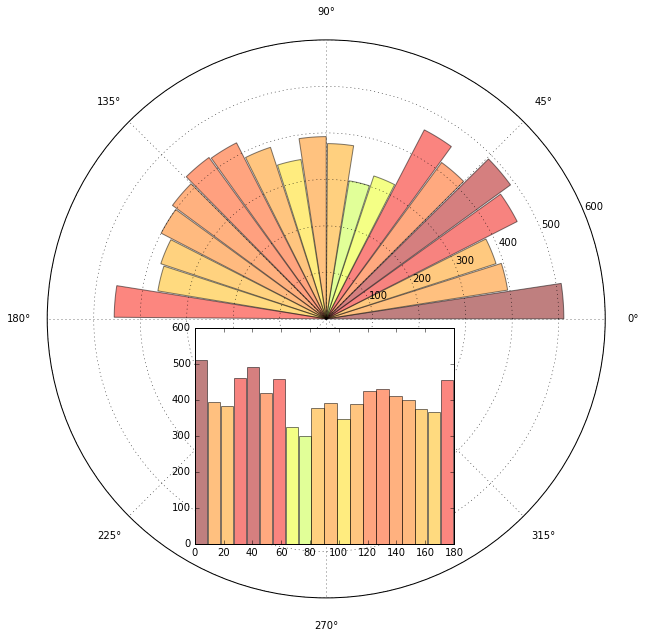

In [183]:
X = out[1]
normedQ = np.arctan2(X.sinQ, X.cosQ ) + 0.5* np.pi

freq, theta = np.histogram(normedQ, 
                           bins='auto',
#                            normed=1,
                          )
width = np.pi/len(theta)
amp = freq.max()*1.

Fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True )

bars = ax.bar(theta[:-1], freq, width=width, )#bottom=amp/2)

# Use custom colors and opacity
for f, bar in zip(freq, bars):
    bar.set_facecolor(plt.cm.jet(f/amp))
    bar.set_alpha(0.5)
    
ax_ = Fig.add_axes([0.33, .2, .36, .3], 
#                axisbg='y'
              )
bars_ = ax_.bar(theta[:-1]/np.pi*180, freq, width=width/np.pi*180,)
for f, bar_ in zip(freq, bars_):
    bar_.set_facecolor(plt.cm.jet(f/amp))
    bar_.set_alpha(0.5)

for fmt in ['eps','png']:
    plt.savefig('{}/{}_slope_hist.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)


### Square cell test 


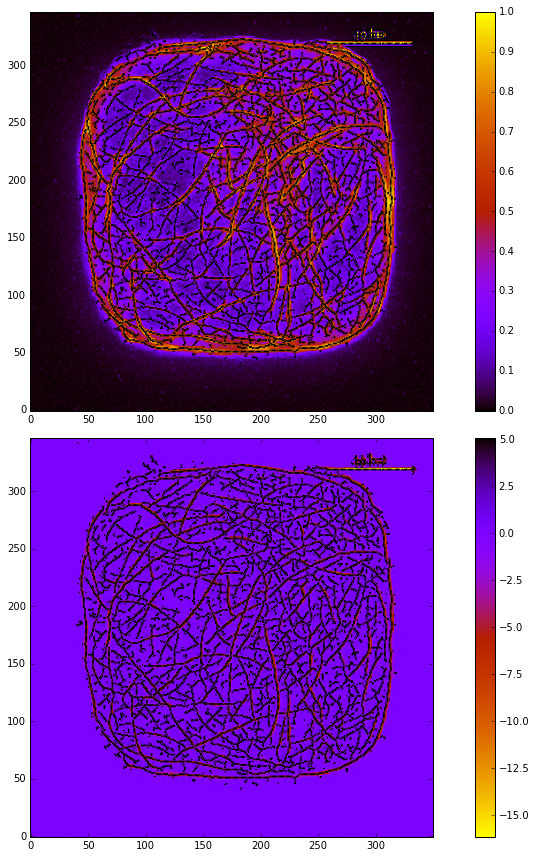

In [24]:
img_name = '../20160929/square2d for eldad.png'
img = plt.imread(img_name)[...,0] #[100:320,100:370]
try:
    val_range = np.iinfo(img.dtype)
    m,M = val_range.min, val_range.max
except:
    m,M = img.min(), img.max()

img -= m
img = img*1./(M-m)

# out = interact(pipeline, img=fixed(img),
interact(pipeline, img=fixed(img), 
         sigma=(0.1,10,0.1), curv_thresh=(-10,.1,0.01), 
         arr_colour=['black','yellow','green','blue','cyan','none'])

plt.tight_layout()

for fmt in ['eps','png']:
    plt.savefig('{}/{}_bar.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)


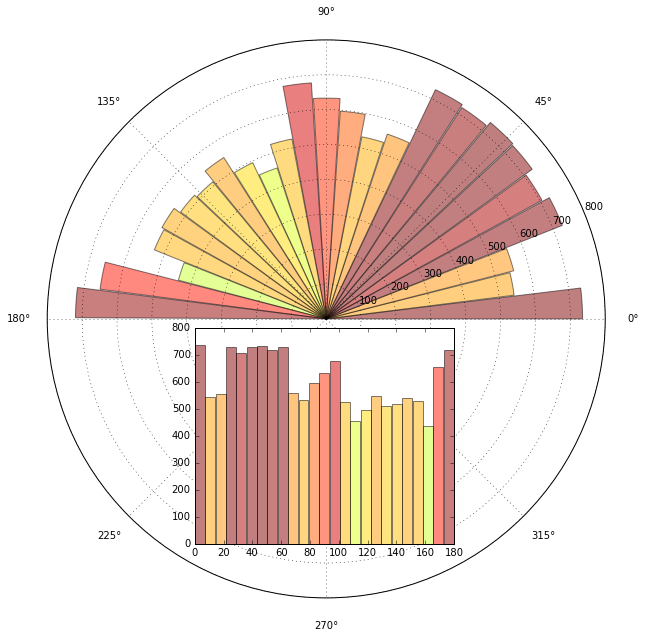

In [25]:
X = out[1]
normedQ = np.arctan2(X.sinQ, X.cosQ ) + 0.5* np.pi

freq, theta = np.histogram(normedQ, 
                           bins='auto',
#                            normed=1,
                          )
width = np.pi/len(theta)
amp = freq.max()*1.

Fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True )

bars = ax.bar(theta[:-1], freq, width=width, )#bottom=amp/2)

# Use custom colors and opacity
for f, bar in zip(freq, bars):
    bar.set_facecolor(plt.cm.jet(f/amp))
    bar.set_alpha(0.5)
    
ax_ = Fig.add_axes([0.33, .2, .36, .3], 
#                axisbg='y'
              )
bars_ = ax_.bar(theta[:-1]/np.pi*180, freq, width=width/np.pi*180,)
for f, bar_ in zip(freq, bars_):
    bar_.set_facecolor(plt.cm.jet(f/amp))
    bar_.set_alpha(0.5)

for fmt in ['eps','png']:
    plt.savefig('{}/{}_slope_hist_bar.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)


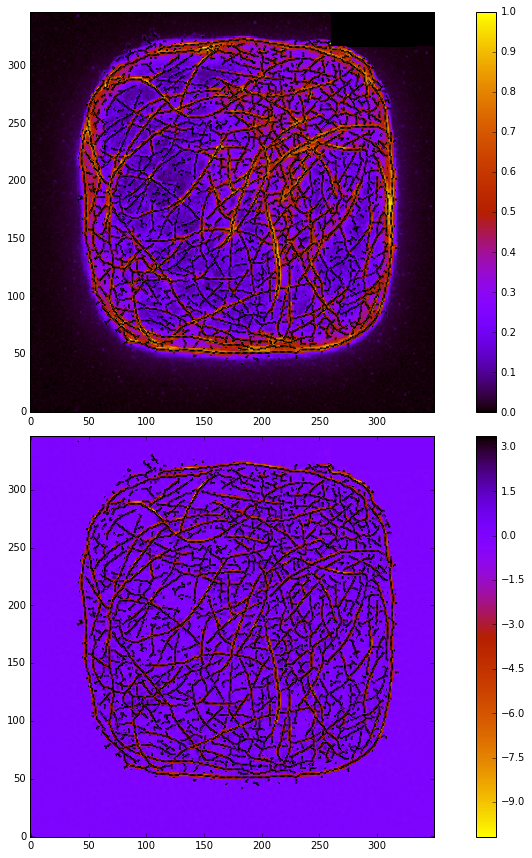

In [40]:
img_name = '../20160929/square2d for eldad.png'
img = plt.imread(img_name)[...,0]
## erase the scale bar
img[317::,260::] = 0
try:
    val_range = np.iinfo(img.dtype)
    m,M = val_range.min, val_range.max
except:
    m,M = img.min(), img.max()

img -= m
img = img*1./(M-m)

# out = interact(pipeline, img=fixed(img),
interact(pipeline, img=fixed(img), 
         sigma=(0.1,10,0.1), curv_thresh=(-10,.1,0.01), 
         arr_colour=['black','yellow','green','blue','cyan','none'])

plt.tight_layout()

for fmt in ['eps','png']:
    plt.savefig('{}/{}.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)


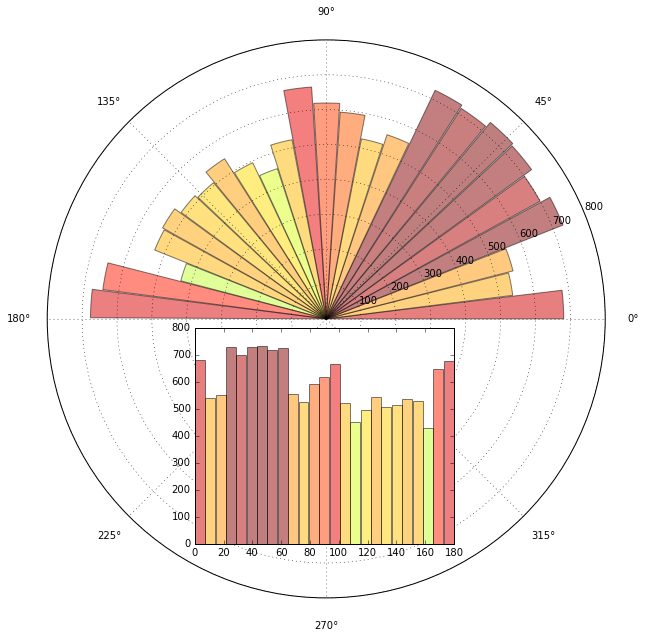

In [41]:
X = out[1]
normedQ = np.arctan2(X.sinQ, X.cosQ ) + 0.5* np.pi

freq, theta = np.histogram(normedQ, 
                           bins='auto',
#                            normed=1,
                          )
width = np.pi/len(theta)
amp = freq.max()*1.

Fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True )

bars = ax.bar(theta[:-1], freq, width=width, )#bottom=amp/2)

# Use custom colors and opacity
for f, bar in zip(freq, bars):
    bar.set_facecolor(plt.cm.jet(f/amp))
    bar.set_alpha(0.5)
    
ax_ = Fig.add_axes([0.33, .2, .36, .3], 
#                axisbg='y'
              )
bars_ = ax_.bar(theta[:-1]/np.pi*180, freq, width=width/np.pi*180,)
for f, bar_ in zip(freq, bars_):
    bar_.set_facecolor(plt.cm.jet(f/amp))
    bar_.set_alpha(0.5)

for fmt in ['eps','png']:
    plt.savefig('{}/{}_slope_hist.{}'.format(fig_out_dir, os.path.split(img_name)[-1][:-4],fmt), dpi=300 if fmt=='png' else None)
